# DSB-2018 dataset EDA

## Briefly description

This dataset contains a large number of segmented nuclei images. The images were acquired under a variety of conditions and vary in the cell type, magnification, and imaging modality (brightfield vs. fluorescence). The dataset is designed to challenge an algorithm's ability to generalize across these variations.

Each image is represented by an associated ImageId. Files belonging to an image are contained in a folder with this ImageId. Within this folder are two subfolders:

- images contains the image file.
- masks contains the segmented masks of each nucleus. This folder is only included in the training set. Each mask contains one nucleus. Masks are not allowed to overlap (no pixel belongs to two masks).

Evaluation metric : Dice Coefficient ( https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2 )

 
Full description of competition and dataset you can read here: https://www.kaggle.com/c/data-science-bowl-2018 .


In [1]:
%matplotlib inline
import cv2
from dsb import DSB
from matplotlib import pyplot as plt
import numpy as np
import os

Using TensorFlow backend.
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Future

## Metric

In [2]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

## Some scripts for visualization

In [3]:
def show_empty_masks(image_dir, mask_dir, rows, cols, figsize=(20,10)):
    image_names = os.listdir(image_dir)
    # mask_names = os.listdir(mask_dir)
    image_names = [name for name in image_names if os.path.isfile(os.path.join(image_dir, name))]
    image_names.sort()
    plt.figure(figsize=figsize,dpi=200)
    index = 0
    for image_name in image_names:
        image = cv2.imread(os.path.join(image_dir, image_name), 0)
        mask = cv2.imread(os.path.join(mask_dir, image_name), 0)
        if np.max(mask)<1:
            name_parts = image_name.split('_')
            title = name_parts[0][:5] + '...' + name_parts[1]
            data_row = index//cols
            if data_row >= rows:
                break
            data_col = index - (data_row*cols)
            image_row = data_row*2
            mask_row = image_row + 1
            plt.subplot2grid((rows*2,cols),(image_row, data_col))
            plt.imshow(image, cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title(title)
            plt.subplot2grid((rows*2,cols),(mask_row, data_col))
            plt.imshow(mask,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            index += 1
    plt.tight_layout()
    plt.show()
    
    
def show_data(dataset, rows, cols, figsize=(20,10)):
    generator = dataset.generator()
    show_data_from_generator(generator, rows, cols, figsize)
    
    
def show_data_from_generator(generator, rows, cols, figsize=(20, 10)):
    plt.figure(figsize=figsize,dpi=200)
    index = 0
    for data in generator:
        name = None
        image = data[0]
        mask = data[1]
        if len(data) > 2:
            name = data[2]
        data_row = index//cols
        if data_row >= rows:
            break
        data_col = index - (data_row*cols)
        image_row = data_row*2
        mask_row = image_row + 1
        plt.subplot2grid((rows*2,cols),(image_row, data_col))
        if len(image.shape) == 4:
            image = image[0, :, :, 0]
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        if name is not None:
            plt.title(name[:8] + '...' + name[-3:])
        plt.subplot2grid((rows*2,cols),(mask_row, data_col))
        if len(mask.shape) == 4:
            mask = mask[0, :, :, 0]
        plt.imshow(mask,cmap='gray')
        plt.title(str(mask.shape[0]) + 'x' + str(mask.shape[1]))
        plt.xticks([])
        plt.yticks([])
        index += 1
    plt.tight_layout()
    plt.show()

## Create dataset class and download the dataset

In [4]:
DATASET_PATH = './datasets/'

dataset = DSB(DATASET_PATH)

## Review of original images and corresponded masks
The helper class combines masks of separated nucleus to a slide mask which contains outlines of all nuclei in the slide. The dataset class provides a generator that allows iterating through images and combined masks. Picture below shows a subset of the dataset. One row or the picture shows original images, another - corresponded combined masks.
The dataset contains images of different sizes and different brightness.

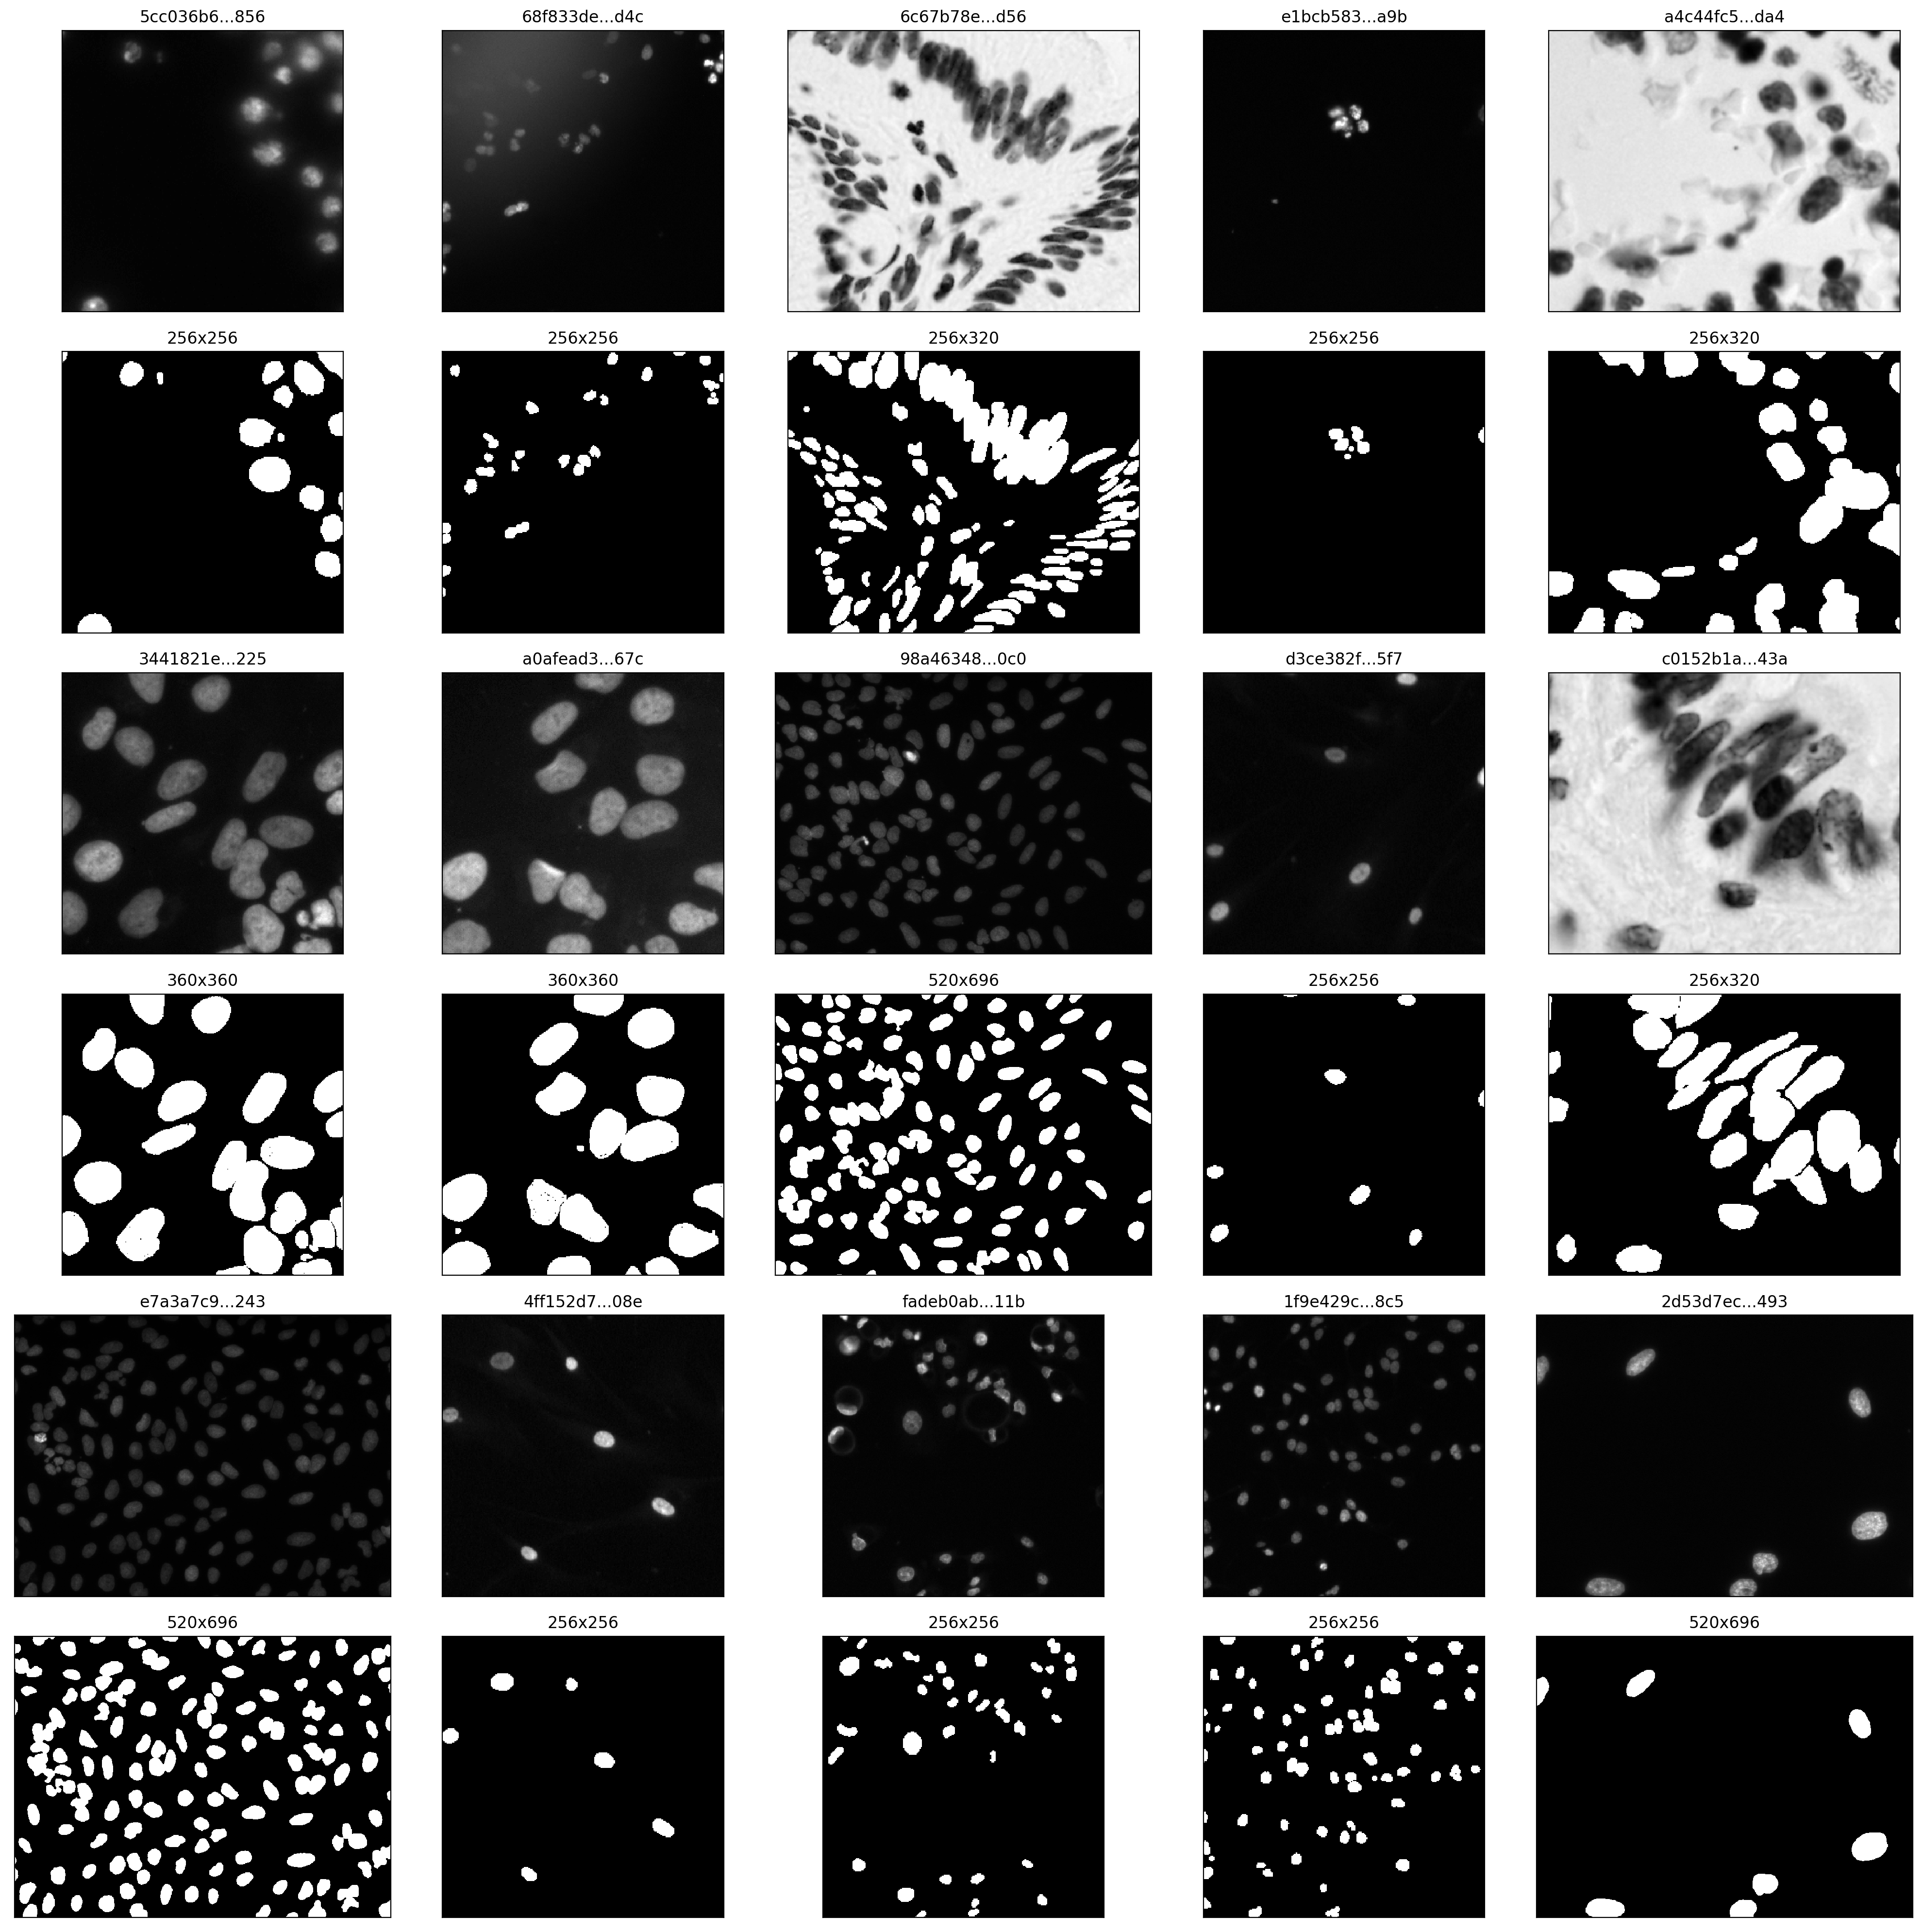

In [5]:
generator = dataset.source_generator()
show_data_from_generator(generator, 3, 5, (20, 20))

## Create training, validation and test sets
In order to create representative training, validation and test image sets we need that images of different types are represented equaly by different sets. To achieve it, we create clusters of images according to their sizes and raster statistics.

**Create a pandas DataFrame object with image parameters**

In [6]:
df = dataset.compute_image_stats()
df.head()

name       min       max  \
0  5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9...  0.003922  0.337255   
1  68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254...  0.035294  1.000000   
2  6c67b78e8164801059375ed9a607f61e67a7ae347e92e3...  0.129412  0.705882   
3  e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13...  0.039216  1.000000   
4  a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9...  0.152941  0.866667   

        std      mean  width  height  
0  0.036769  0.024135   0.25  0.2500  
1  0.096287  0.123578   0.25  0.2500  
2  0.149854  0.552929   0.25  0.3125  
3  0.051605  0.057424   0.25  0.2500  
4  0.155740  0.706031   0.25  0.3125

**Split dataset by 8 clasters according to their statistics and size**

In [7]:
dataset.create_image_clusters(df, cluster_count=8)
df.head()

name       min       max  \
0  5cc036b65f7f2d5480e2be111a561f3713ac021683a9a9...  0.003922  0.337255   
1  68f833de9f8c631cedd7031b8ed9b908c42cbbc1e14254...  0.035294  1.000000   
2  6c67b78e8164801059375ed9a607f61e67a7ae347e92e3...  0.129412  0.705882   
3  e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13...  0.039216  1.000000   
4  a4c44fc5f5bf213e2be6091ccaed49d8bf039d78f6fbd9...  0.152941  0.866667   

        std      mean  width  height  cluster  
0  0.036769  0.024135   0.25  0.2500        6  
1  0.096287  0.123578   0.25  0.2500        3  
2  0.149854  0.552929   0.25  0.3125        2  
3  0.051605  0.057424   0.25  0.2500        3  
4  0.155740  0.706031   0.25  0.3125        2

**Visualize different clusters**
Picture below shows first 10 images from each of 8 clusters

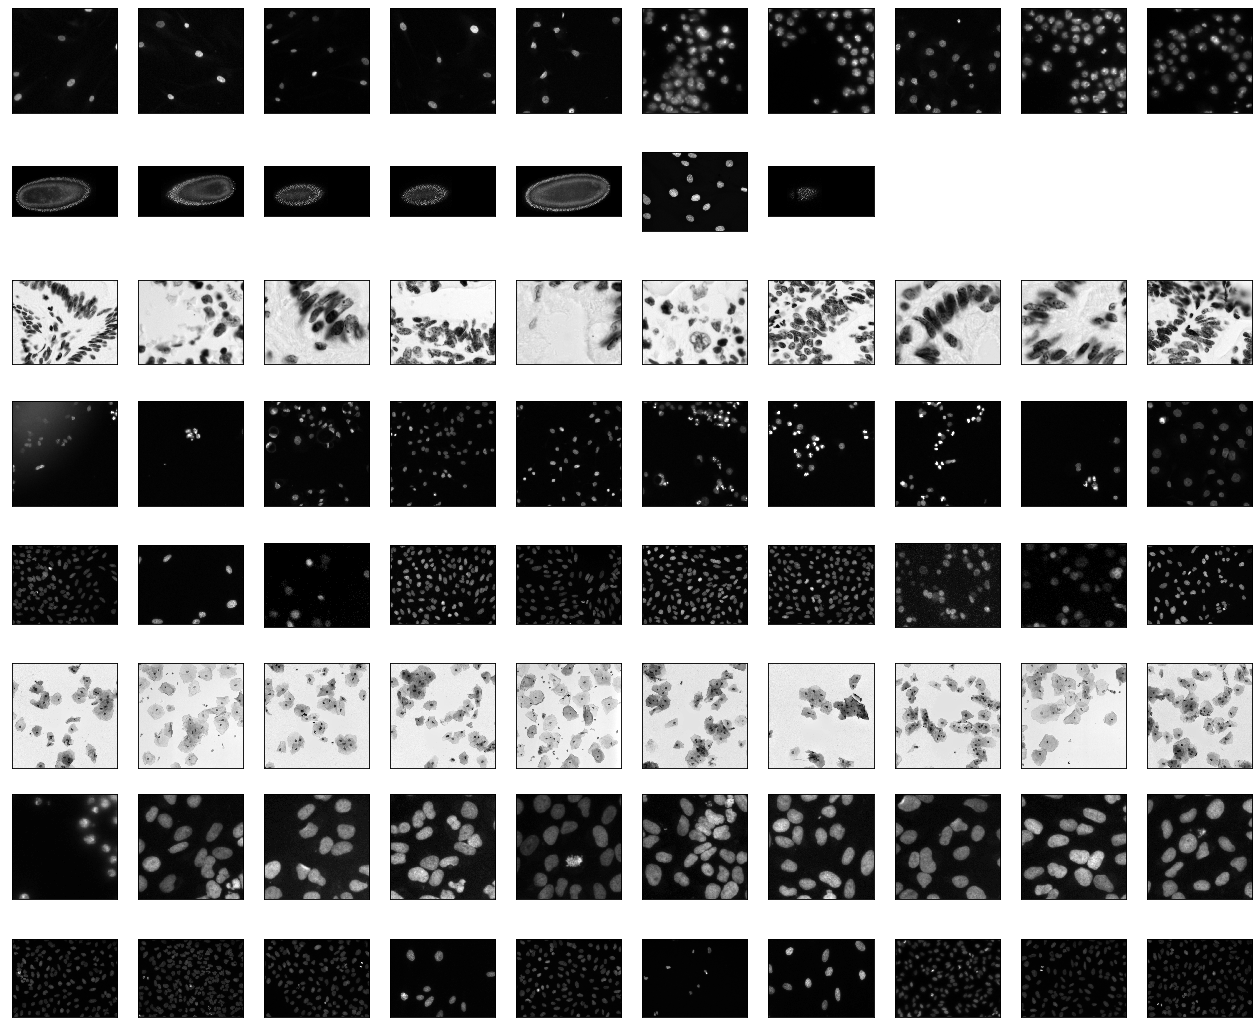

In [8]:
clusters = df.cluster.max() + 1
cols = 10
rows = clusters
plt.figure(figsize=(20, 17), dpi=80)

for cluster in range(clusters):
    df0 = df[df.cluster == cluster]
    image_num = 0
    for index, image_info in df0.iterrows():
        image_name = image_info['name']
        image_path = os.path.join(DATASET_PATH, image_name, 'images', image_name + '.png')
        image = cv2.imread(image_path, 0)
        image = image/255.
        plt.subplot2grid((rows, cols),(cluster, image_num))
        plt.imshow(image, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        image_num += 1
        if image_num >= cols:
            break
plt.show()

## Dataset preparation
***prepare*** method of the dataset helper splits the dataset in 3 subsets for training, validation and testing.
It performes as well following operations:
- combination of a slide masks in a single mask with outlines of all slide nuclei;
- invert bright slides;
- defines the training, validation and test datasets by clustering of images according to the image raster statistics and making sure that each set contains equal amount of images from the clusters; 
- splits slides to tiles 256x256. The tiles normally overlap with each other;

In [9]:
dataset.prepare()

### Show some preprocessed training images
This section shows 256x256 tiles created from the original images together with corresponded masks

Found 1948 images belonging to 1 classes.
Found 1948 images belonging to 1 classes.


//anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


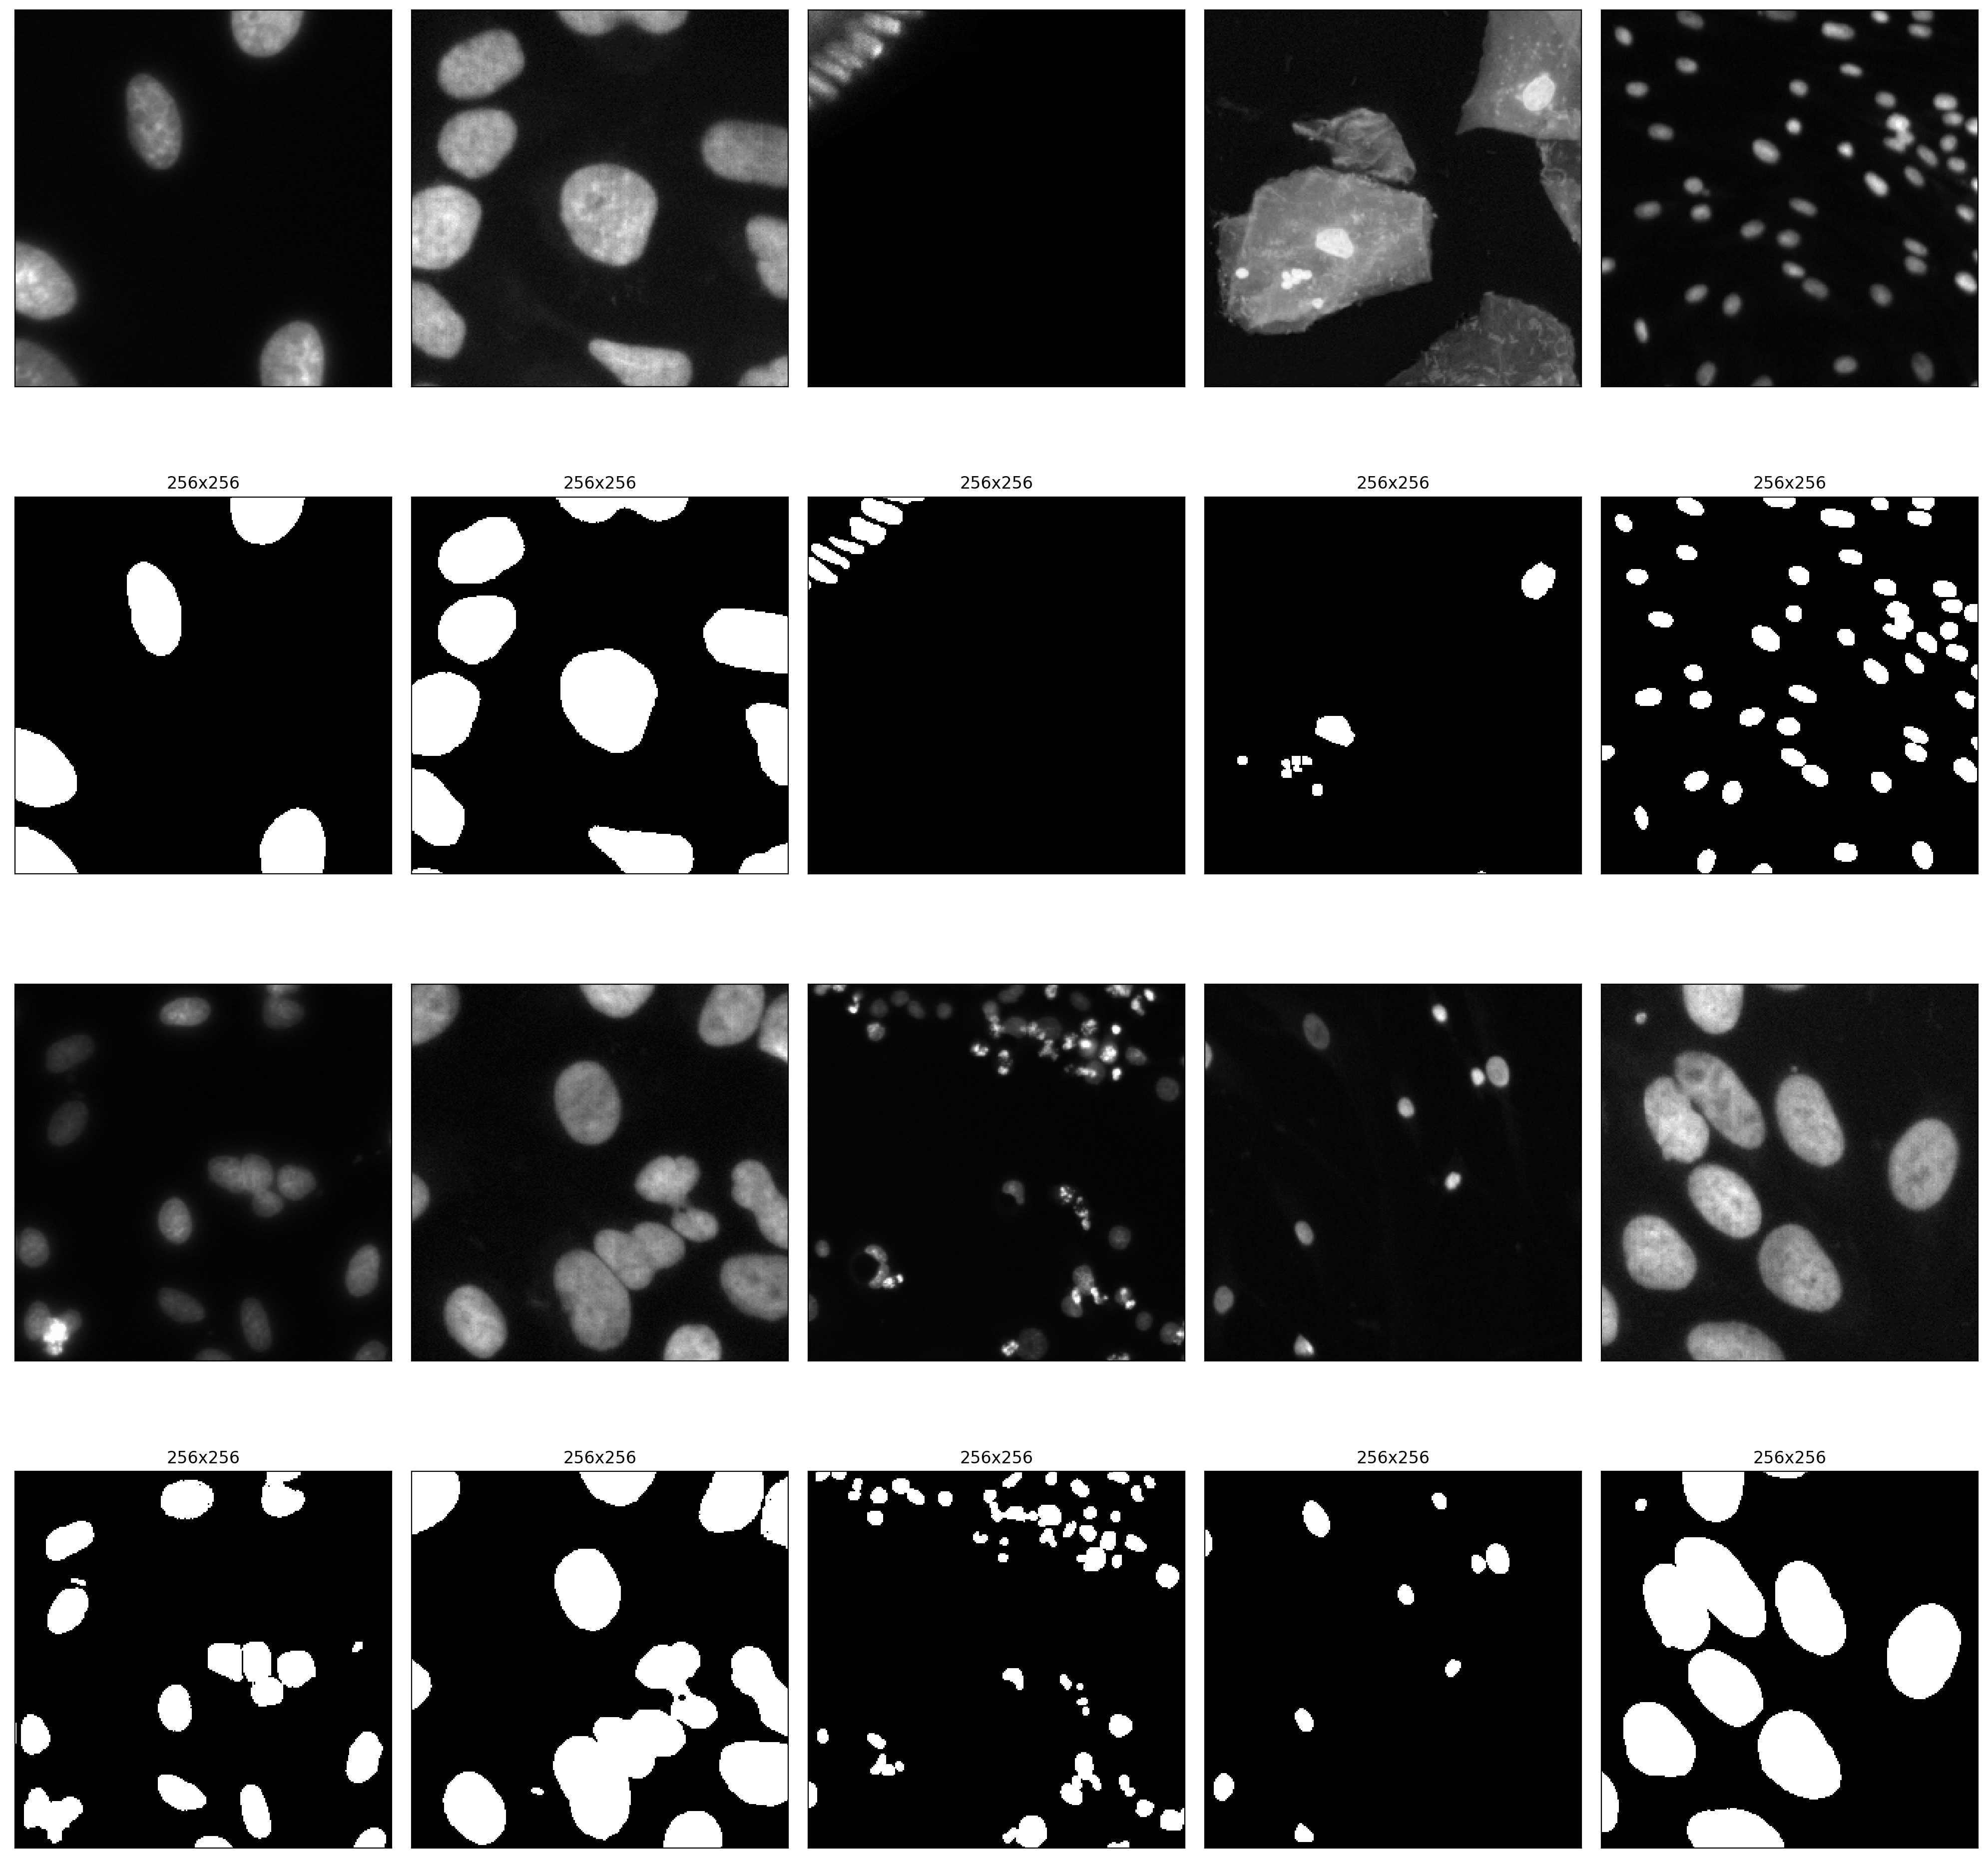

In [10]:
generator = dataset.generator(mode='training')
show_data_from_generator(generator, 2, 5, (20, 20))

Found 197 images belonging to 1 classes.
Found 197 images belonging to 1 classes.


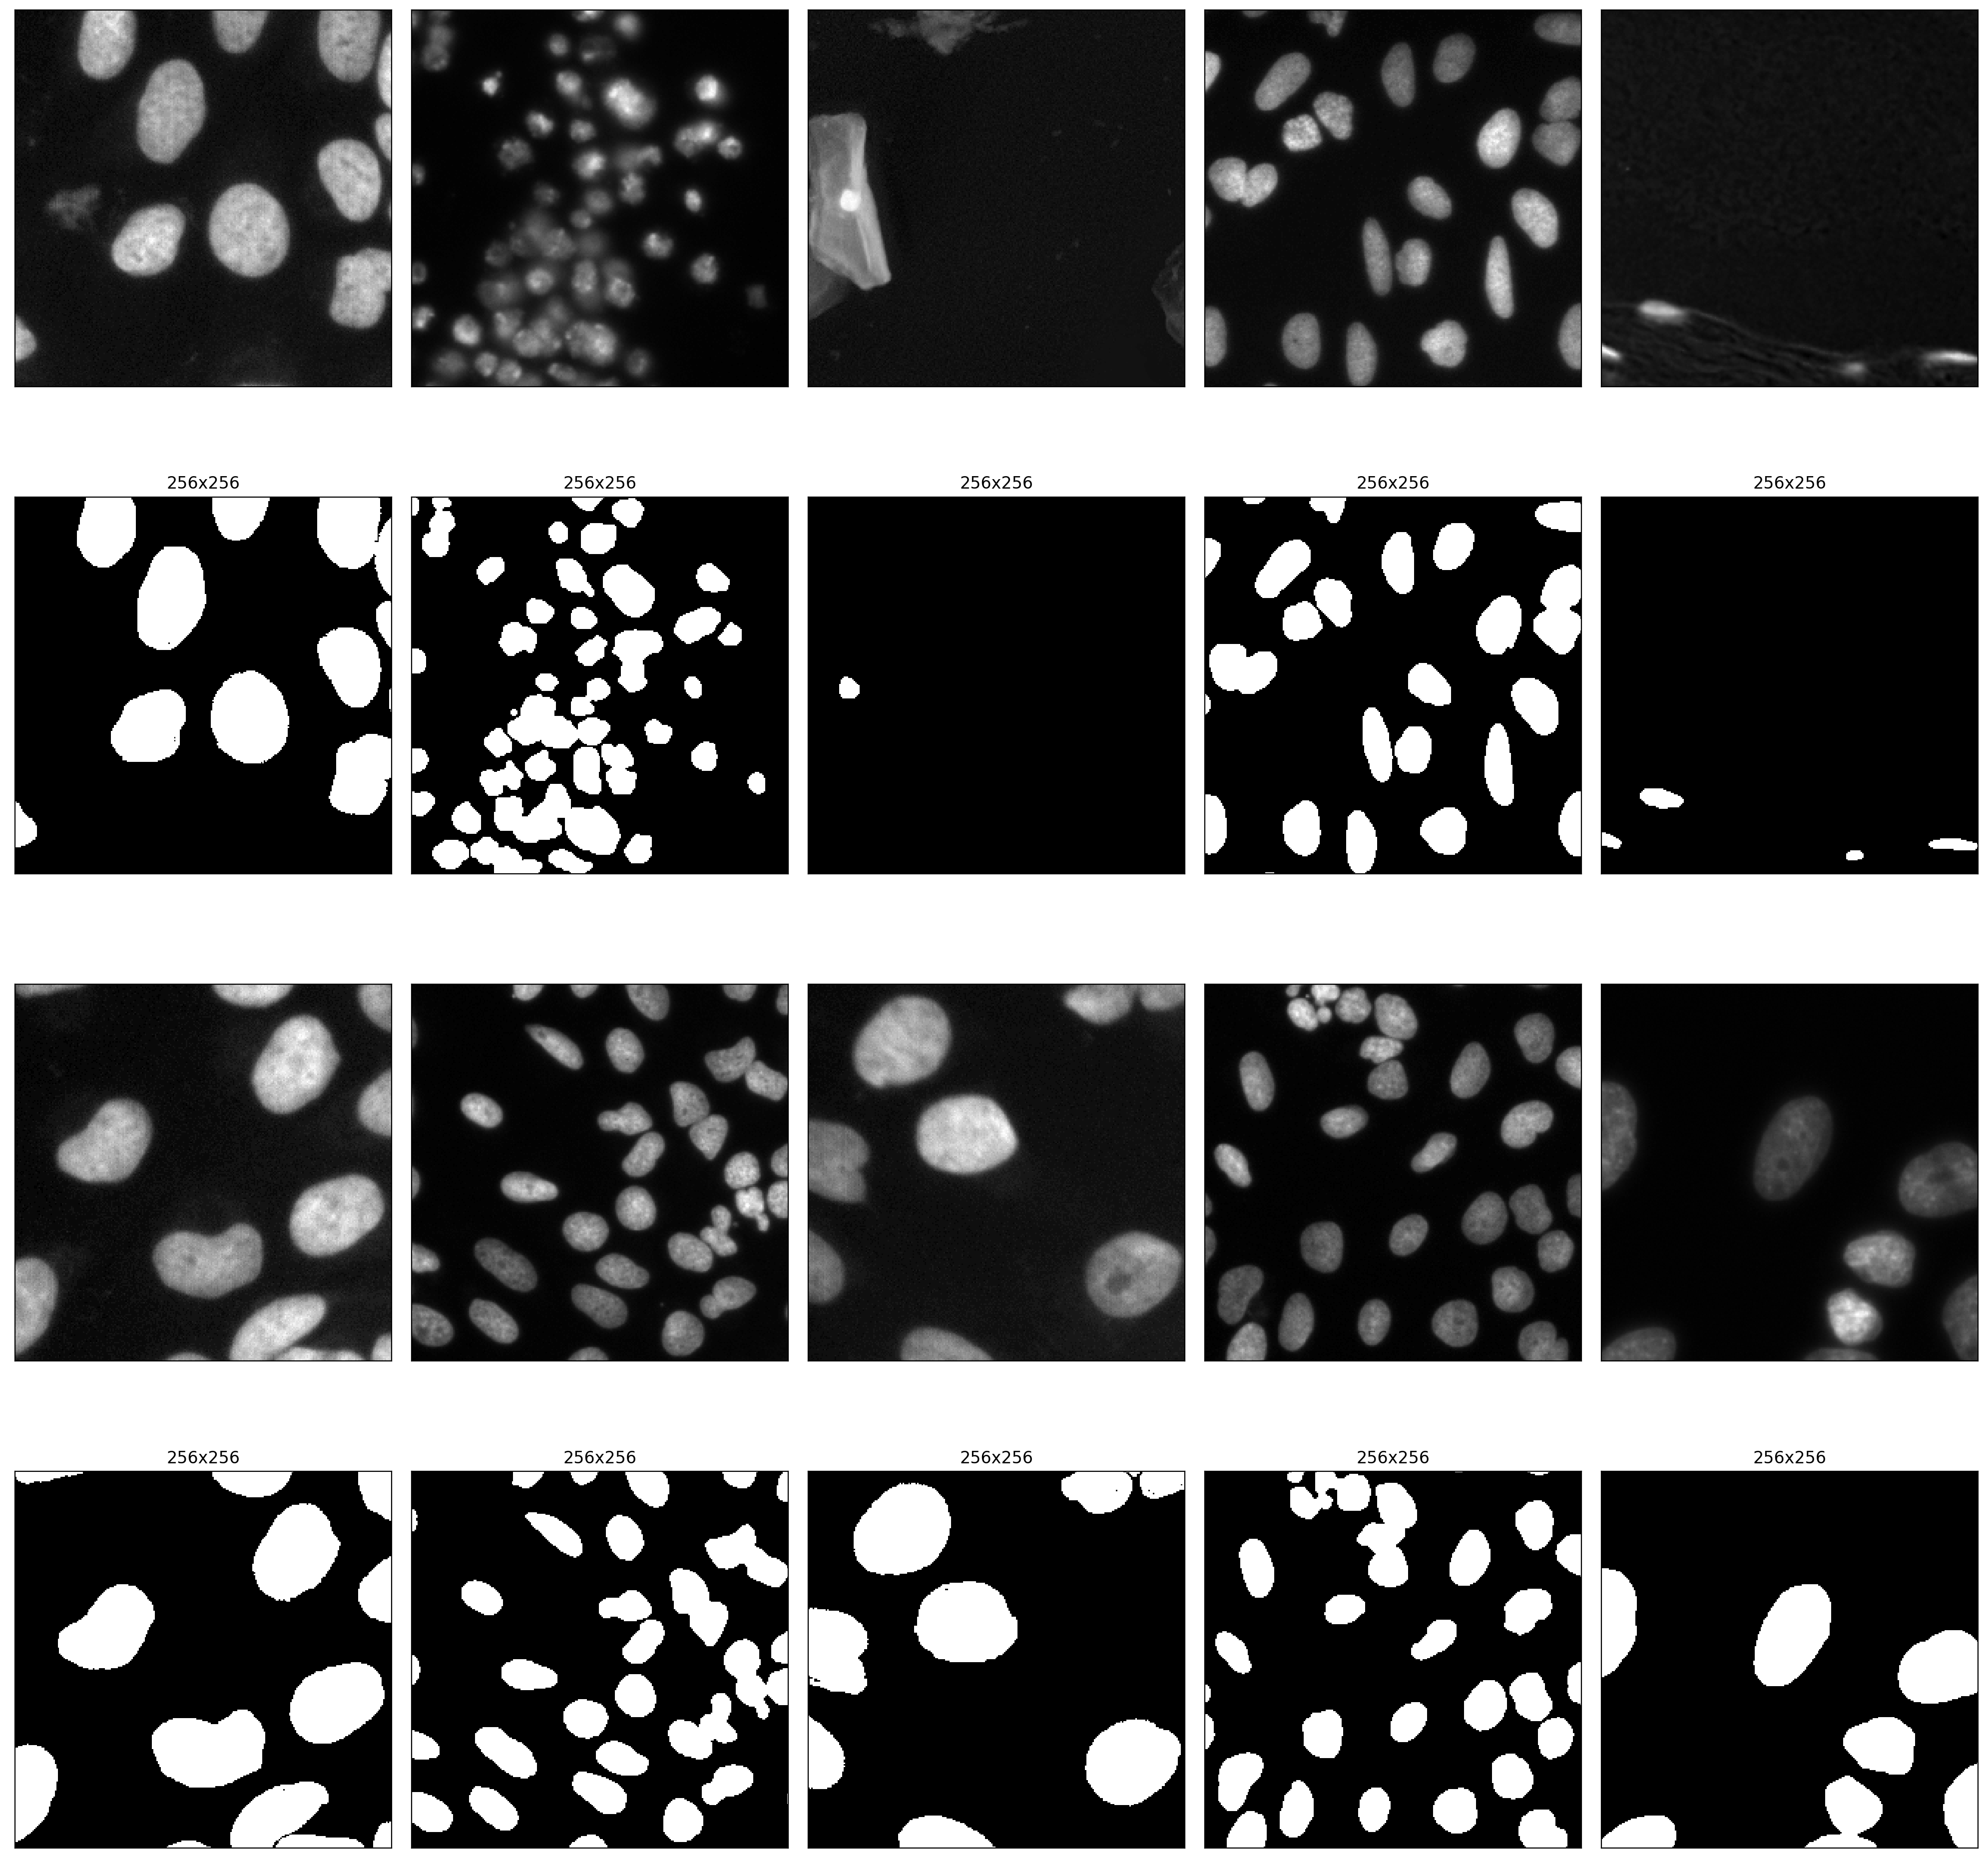

In [11]:
generator = dataset.generator(mode='validation')
show_data_from_generator(generator, 2, 5, (20, 20))

##  Testing images (not preprocessed)
This section shows test images and corresponded nucleus masks. The images are not tiled nor preprocess. Tiling, preprocessing and combining of the prediction results occurs in the inferrence process.

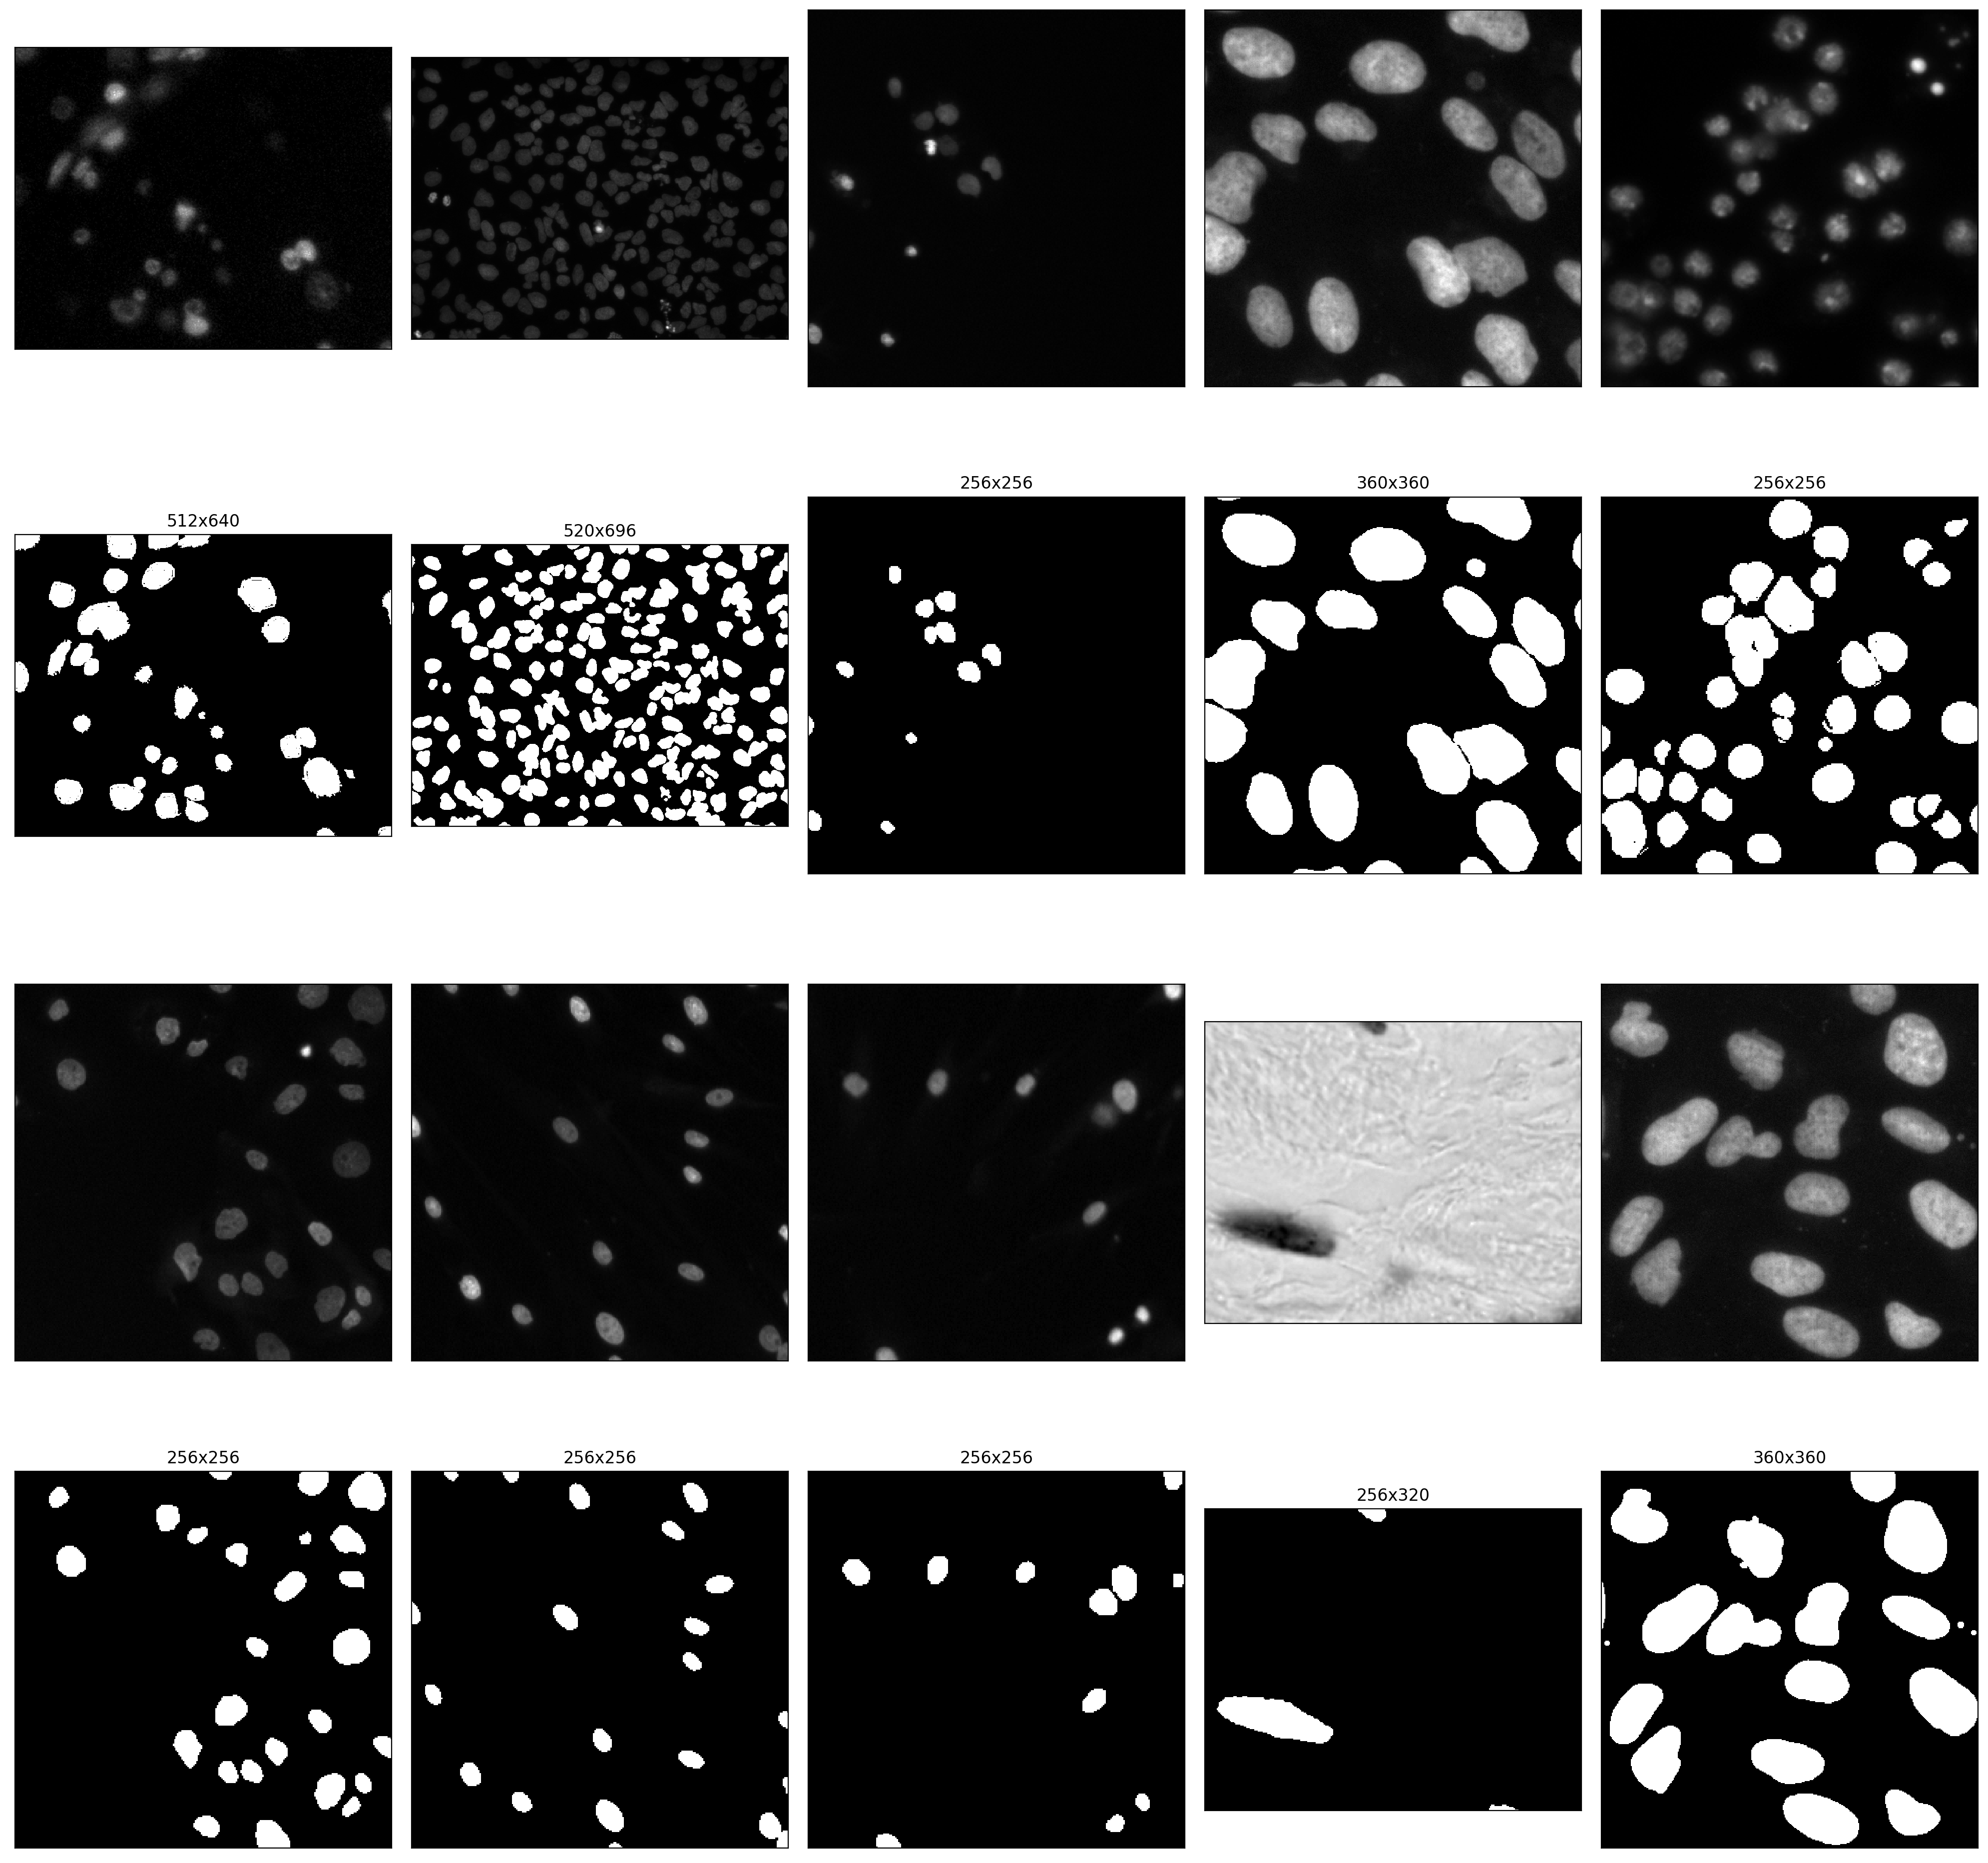

In [12]:
generator = dataset.generator(mode='test')
show_data_from_generator(generator, 2, 5, (20, 20))

In [13]:
dataset.clear()